## Utility functions


In [1]:
%matplotlib inline
from nltk.cluster.kmeans import KMeansClusterer
import nltk
import pickle

import torch
from pytorch_pretrained_bert import BertTokenizer, BertConfig, BertModel
from pytorch_pretrained_bert.modeling import BertPreTrainedModel, BertPreTrainingHeads
import numpy as np
from scipy.spatial.distance import cosine
import pickle
import re
import pandas as pd
device = 'cpu'
import sys
import os

import json


In [2]:
class BertForPreTraining_custom(BertPreTrainedModel):
    def __init__(self, config):
        super(BertForPreTraining_custom, self).__init__(config)
        self.bert = BertModel(config)
        self.cls = BertPreTrainingHeads(config, self.bert.embeddings.word_embeddings.weight)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, masked_lm_labels=None, next_sentence_label=None):
        output_all_encoded_layers=True
        sequence_output, pooled_output = self.bert(input_ids, token_type_ids, attention_mask,
                                                   output_all_encoded_layers=output_all_encoded_layers)
        if output_all_encoded_layers:
            sequence_output_pred = sequence_output[-1]
        prediction_scores, seq_relationship_score = self.cls(sequence_output_pred, pooled_output)
        return prediction_scores, seq_relationship_score, sequence_output, pooled_output 
    
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
config = BertConfig.from_json_file('../data/bert_config.json')
bert_model = 'bert-base-uncased'

In [3]:
def getNSPScore(sample_text):
    
    m = torch.nn.Softmax()

    tokenized_text = tokenizer.tokenize(sample_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    segments_ids = [0]*tokenized_text.index('[SEP]')+[1]*(len(tokenized_text)-tokenized_text.index('[SEP]'))

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    pred_score, seq_rel, seq_out, pool_out = model1(tokens_tensor, segments_tensors)
    return m(seq_rel).detach().numpy()[0][0] #returns probability of being next sentence

def getSentMatchScore(sent1, sent2, nsp_dampening_factor = 0.7):
    
    sent1_feats = getBERTFeatures(model1, sent1, attn_head_idx)
    sent2_feats = getBERTFeatures(model1, sent2, attn_head_idx)
    
    cosine_distance = 1- cosine(sent1_feats, sent2_feats)
    
    nsp_input1 = sent1+' [SEP] '+sent2
    nsp_input2 = sent2+' [SEP] '+sent1
    
    nsp_score_1 = getNSPScore(nsp_input1)
    nsp_score_2 = getNSPScore(nsp_input2)
    nsp_score = np.mean([nsp_score_1,nsp_score_2])*nsp_dampening_factor
    
    len_diff = abs(len(sent1.split(' '))-len(sent2.split(' ')))
    if len_diff>2*(min(len(sent1.split(' ')),len(sent2.split(' ')))):
        #give more weight to nsp if the sentences of largely varying lengths
        score = 0.4*cosine_distance+0.6*nsp_score
    else:
        score = np.mean([cosine_distance,nsp_score])
    
    #print ("nsp score -> " + str(nsp_score))
    #print ("cosine score -> " + str(cosine_distance))
    return score
    

def getSentMatchScore_wfeature(sent1, sent2, sent1_feats, sent2_feats, nsp_dampening_factor = 0.7):
    cosine_distance = 1-cosine(sent1_feats, sent2_feats)
    
    #return cosine_distance
    nsp_input1 = sent1+' [SEP] '+sent2
    #nsp_input2 = sent2+' [SEP] '+sent1
    
    nsp_score_1 = getNSPScore(nsp_input1)
    #nsp_score_2 = getNSPScore(nsp_input2)
    
    nsp_score = nsp_score_1 * nsp_dampening_factor
    #nsp_score = nsp_score_1*nsp_dampening_factor
    
    len_diff = abs(len(sent1.split(' '))-len(sent2.split(' ')))
    if len_diff>2*(min(len(sent1.split(' ')),len(sent2.split(' ')))):
        #give more weight to nsp if the sentences of largely varying lengths
        score = 0.4*cosine_distance+0.6*nsp_score
    else:
        score = np.mean([cosine_distance,nsp_score])
    
    return score

def getSentMatchScore_wfeature_cosine(sent1, sent2, sent1_feats, sent2_feats, nsp_dampening_factor = 0.7):
    cosine_distance = 1-cosine(sent1_feats, sent2_feats)
    
    return cosine_distance
    

def getSentMatchScore_wfeature_test(sent1, sent2, sent1_feats, sent2_feats, nsp_dampening_factor = 0.7):
    cosine_distance = 1-cosine(sent1_feats, sent2_feats)
    
    nsp_input1 = sent1+' [SEP] '+sent2
    nsp_input2 = sent2+' [SEP] '+sent1
    
    nsp_score_1 = getNSPScore(nsp_input1)
    nsp_score_2 = getNSPScore(nsp_input2)
    
    nsp_score = np.mean([nsp_score_1,nsp_score_2])*nsp_dampening_factor
    #nsp_score = nsp_score_1*nsp_dampening_factor
    
    len_diff = abs(len(sent1.split(' '))-len(sent2.split(' ')))
    if len_diff>2*(min(len(sent1.split(' ')),len(sent2.split(' ')))):
        #give more weight to nsp if the sentences of largely varying lengths
        score = 0.4*cosine_distance+0.6*nsp_score
    else:
        score = np.mean([cosine_distance,nsp_score])
    
    return score, cosine_distance, nsp_score
def getBERTFeatures(model, text, attn_head_idx = -1): #attn_head_idx - index o[]
    tokenized_text = tokenizer.tokenize(text)
    if len(tokenized_text)>200:
        tokenized_text = tokenized_text[0:200]
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    _, _, seq_out, pool_out = model(tokens_tensor)
    seq_out = list(getPooledFeatures(seq_out[attn_head_idx]).T)
    #pool_out = list(pool_out.detach().numpy().T)
    
    return seq_out

def getPooledFeatures(np_array):
    np_array = np_array.reshape(np_array.shape[1],np_array.shape[2]).detach().numpy()
    np_array_mp = np.mean(np_array, axis=0).reshape(1, -1)
    return np_array_mp

def replaceContractions(text):
    #text = text.lower()
    c_filt_text = ''
    for word in text.split(' '):
        if word in contractions:
            c_filt_text = c_filt_text+' '+contractions[word]
        else:
            c_filt_text = c_filt_text+' '+word
    return c_filt_text

def cleanText(text):
        
    text = text.replace('\\n','')
    text = text.replace('\\','')
    #text = text.replace('\t', '')
    #text = re.sub('\[(.*?)\]','',text) #removes [this one]
    text = re.sub('(http:\/\/www\.|https:\/\/www\.|http:\/\/|https:\/\/)?[a-z0-9]+([\-\.]{1}[a-z0-9]+)*\.[a-z]{2,5}(:[0-9]{1,5})?(\/.*)?\s',
                ' __url__ ',text) #remove urls
    #text = re.sub('\'','',text)
    #text = re.sub(r'\d+', ' __number__ ', text) #replaces numbers
    text = re.sub('\W', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.replace('\t', '')
    text = text.replace('\n', '')
    return text

In [4]:
model1 = BertForPreTraining_custom(config)
model1.to(device)
#state_dict_1 = torch.load('/home/ether/domain_mind/ai/bert_10epc_ai_ds_1e-6_sl40.bin')
state_dict_1 = torch.load('../data/bert_10epc_se_1e-6_sl40.bin')
model1.load_state_dict(state_dict_1)
model1.eval()

BertForPreTraining_custom(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): 

In [6]:
def parsemeeting(text):
    with open(text, 'r') as f:
        parsed_text = json.load(f)
    return parsed_text
text = parsemeeting('../data/meeting_transcript_sync.json')

In [77]:
texts = ''
temp = ' '
for t in text['timeline']['transcriptSegments']:
    temp = ' ' +  t['text']
    texts = texts + temp
    

In [78]:
texts

" Was able to add certificate which for developer developer ID legacy. Yes basically got anything add and anything else nothing think I just. So so we had this. But because we have a tested I want to set at this point, but we do need to be process on the fact that we we might need just to terms for production. Maybe what they can account itself comes are something like. Yeah it is not directly directly depending for. Then we were just taking online on the call was promising and we saw a few errors not with respect to segment failures or these kind of things would be something similar to that. I see it is giving fine art for sometimes the response from mind service. And the record inclined one second today. I will do one more PASS testing under at least with the basic functionality. We can should be should be able to push it to production. Maybe we're and we're trying to push a do your production deflected a will try to push this thing along with that and if we think there is anything a

## get Communities from meetings.

In [79]:
import sys, pickle
sys.path.append('../')
import text_preprocessing.preprocess as tp

# with open('../data/Engineering_Mind_Test_Transcripts.txt','r') as fp:
#     texts = fp.read()

mod_texts_unfiltered = tp.preprocess(texts, stop_words=False, remove_punct=True)
mod_texts = []

for index, sent in enumerate(mod_texts_unfiltered):
    if len(sent.split(' '))>250:
        length = len(sent.split(' '))
        split1 = ' '.join([i for i in sent.split(' ')[:round(length/2)]])
        split2 = ' '.join([i for i in sent.split(' ')[round(length/2):]])
        mod_texts.append(split1)
        mod_texts.append(split2)
        continue
        #mod_texts.pop(index)
    if len(sent.split(' '))<=6:
        continue
    mod_texts.append(sent)

print(len(mod_texts))
fv = {}

for index, sent in enumerate(mod_texts):
    fv[index] = getBERTFeatures(model1, sent, attn_head_idx=-1)
    print (index)

131
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130


In [80]:
import networkx as nx

def build_graph(doc_list):
    eng_graph = nx.Graph()
    try:
        eng_graph.add_nodes_from(range(len(doc_list)))
    except Exception as e:
        print(e)
    return eng_graph


tg = build_graph(mod_texts)

In [81]:
attn_head_idx = -1

node_edge = []

for index1, sent1 in enumerate(mod_texts):
    print (index1)
    for index2, sent2 in enumerate(mod_texts):
        if index1!=index2:
            score = getSentMatchScore_wfeature(sent1, sent2,fv[index1],fv[index2])
#             if score > 0.8:
#                 #tg.add_edge(index1,index2,{'weight': score})
#                 tg.add_edge(index1,index2)
            tg.add_edge(index1,index2,weight=score)

0


/home/ray__/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130


In [89]:
def build_community_graph(tg, mod_texts):
    com_graph = nx.Graph()
    for sent in list(tg.nodes()):
        com_graph.add_node(sent)
    for nodea in tg.nodes():
        for nodeb in tg.nodes():
            if nodea!=nodeb:
                if tg.edges[nodea,nodeb]['weight'] > 0.75:
                    com_graph.add_edge(nodea,nodeb)
    return com_graph
com_graph = build_community_graph(tg, mod_texts)

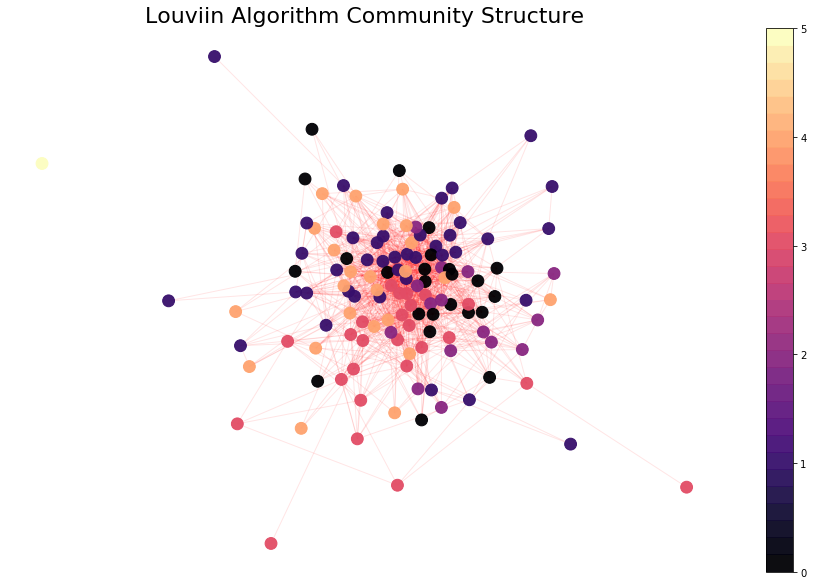

In [90]:
# import community
# import matplotlib.pyplot as plt
# partition = community.best_partition(tg)

# values = [partition.get(node) for node in tg.nodes()]
# values=[partition.get(node) for node in tg.nodes()]
# plt.rcParams['figure.figsize']= [16, 10]
# measure_name = "Louviin Algorithm Community Structure"
# pos = nx.spring_layout(tg, k=0.2, iterations=20)
# nodes_plot=nx.draw_networkx_nodes(tg, pos, node_size=140, label=True, cmap=plt.get_cmap('magma', len(tg.nodes())/4),node_color=values, alpha=0.95)
# edges_plot=nx.draw_networkx_edges(tg, pos, edge_color='r', alpha=0.1)
# plt.title(measure_name, fontsize=22, fontname='Arial')
# plt.colorbar(nodes_plot)
# plt.axis('off')
# plt.show()

import community
import matplotlib.pyplot as plt
partition = community.best_partition(com_graph)

values = [partition.get(node) for node in com_graph.nodes()]
values=[partition.get(node) for node in com_graph.nodes()]
plt.rcParams['figure.figsize']= [16, 10]
measure_name = "Louviin Algorithm Community Structure"
pos = nx.spring_layout(com_graph, k=0.2, iterations=20)
nodes_plot=nx.draw_networkx_nodes(com_graph, pos, node_size=140, label=True, cmap=plt.get_cmap('magma', len(com_graph.nodes())/4),node_color=values, alpha=0.95)
edges_plot=nx.draw_networkx_edges(com_graph, pos, edge_color='r', alpha=0.1)
plt.title(measure_name, fontsize=22, fontname='Arial')
plt.colorbar(nodes_plot)
plt.axis('off')
plt.show()

In [91]:
community.modularity(partition, com_graph)

0.21177762353343693

In [92]:
partition = sorted(partition.items(), key=lambda kv: kv[1], reverse=False)

In [93]:
current = 0
print ("--------------cluster " + str(0) + "------------ \n ")
for word, cluster in partition:
    if cluster!=current:
        print ("--------------cluster " + str(cluster) + "------------ \n ")
        print (mod_texts[word])
        current=cluster
    else:
        print (mod_texts[word])

--------------cluster 0------------ 
 
Was able to add certificate which for developer developer ID legacy.
I will do one more PASS testing under at least with the basic functionality.
Dependency for Partial but I am working on it the functionality.
So with my was able to test even it is an inactive customers but I was not able to a proper message error message saying that okay mean you are far forbidden because you have not active so that type of message.
Any any red Flags with profile no in in time of Subscription.
From time which will not directly affect the partial which is I think that is working on that which is basically adding an authorization test middle that we organization layer from a gateway way to blogs any API calls from inactive customer ID yeah so.
Yeah so mainly I just needed the activation the activation and the account.
Post the License from the host like excellent so.
Guides there is a developer ID certificate present and adds to the build like currently there is i

In [28]:
current = 0
print ("--------------cluster " + str(0) + "------------ \n ")
for word, cluster in partition:
    if cluster!=current:
        print ("--------------cluster " + str(cluster) + "------------ \n ")
        print (word)
        current=cluster
    else:
        print (word)

--------------cluster 0------------ 
 
0
1
5
7
11
14
16
18
19
21
24
27
29
33
34
38
44
47
52
54
62
69
--------------cluster 1------------ 
 
2
6
9
13
15
20
31
32
35
37
39
41
42
43
48
49
50
51
53
56
58
60
65
67
70
73
--------------cluster 2------------ 
 
3
8
10
12
17
--------------cluster 3------------ 
 
4
22
23
61
68
--------------cluster 4------------ 
 
25
26
36
45
46
57
59
63
64
71
72
--------------cluster 5------------ 
 
28
--------------cluster 6------------ 
 
30
--------------cluster 7------------ 
 
40
--------------cluster 8------------ 
 
55
--------------cluster 9------------ 
 
66


In [87]:
com_graph.number_of_edges()

97

In [88]:
tg.number_of_edges()

8515

In [62]:
clusters = []
temp = []
prev_com = 0
for word,cluster in partition:
    if prev_com==cluster:
        temp.append(word)
        #print (temp)
    else:
        clusters.append(temp)
        temp = []
        prev_com = cluster
        temp.append(word)

In [63]:
clusters

[[0, 7, 10, 11, 12, 17, 18, 33, 48],
 [1, 5, 14, 16, 19, 21, 34, 44, 47, 52, 54, 62],
 [2, 20, 31, 39, 51, 56],
 [3],
 [4, 22],
 [6, 36, 37, 38, 50, 70, 72, 73],
 [8],
 [9],
 [13],
 [15],
 [23],
 [24, 26, 27, 29, 46, 53, 69, 71],
 [25],
 [28],
 [30],
 [32],
 [35],
 [40],
 [41],
 [42],
 [43],
 [45],
 [49],
 [55],
 [57],
 [58],
 [59],
 [60],
 [61],
 [63],
 [64],
 [65],
 [66],
 [67]]

In [64]:
new_text = []
temp = ""
for com in clusters:
    new_text.append(' '.join(mod_texts[sent] for sent in com))

In [ ]:
new_text[11]

## Using communities build word graph

In [65]:
from graphrank.graphrank import GraphRank
from graphrank.utils import GraphUtils, TextPreprocess

gr = GraphRank()
tp = TextPreprocess()
utils = GraphUtils()


In [67]:
keyphrases_list = []
for index, com in enumerate(new_text):
    if com!="":
        gr = GraphRank()
        tp = TextPreprocess()
        utils = GraphUtils()

        original_tokens, pos_tuple, filtered_pos_tuple = tp.preprocess_text(com, filter_by_pos=True, pos_filter=['NOUN', 'PROPN', 'ADJ', 'FW'], stop_words=False)

        word_graph = gr.build_word_graph(filtered_pos_tuple, original_tokens=original_tokens, window=4, reset_graph_context=True, preserve_common_words=False)

        keyphrases = gr.get_keyphrases(word_graph, normalize_nodes='degree')
        keyphrases_list.append(keyphrases)

In [68]:
for index, com in enumerate(keyphrases_list):
    print ("--------------Community-----------    " + str(index))
    for keyphrase in com:
        print (keyphrase[0])

--------------Community-----------    0
proper message error
developer
inactive customers
channel domains
easy freddie
red flags
site
voice
tech
api
development
ui
host
tomorrow
license
excellent
point
process
fact
certificate
terms
front
production
login
build
bton
forbidden
issue
type
wrong
website
platform
slot
good
change
click
time
friday
profile
--------------Community-----------    1
mines method
pas zoom sprint time
slack commands force
entire core system
authorization test middle
model current browser
multiple call reason
concurrent execution limit
times speed
slack store
production account
organization layer
google alytics
number project
inactive customer
segment failures
balance time
event keyword
enable loop
final meeting
basic functionality
recording plan
request mode
year request
api calls
test calls
request jobs
current setup
error object
second today
multiple calls
production meeting
appropriate status
point seconds
request today
usa
tweak
activation
pins
platform
guys


## testing topic modelling with LDA

In [148]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in new_text]
#doc_clean = [clean(new_text[1]).split()]

In [149]:
doc_clean

[['back',
  'end',
  'perspective',
  'ready',
  'integrate',
  'think',
  'good',
  'shape',
  'think',
  'shivam',
  'separate',
  'nats',
  'performance',
  'related',
  'change',
  'think',
  'need',
  'approve',
  'thing',
  'think',
  'one',
  'request',
  'yesterday',
  'highest',
  'priority',
  'first',
  'handle',
  'ui',
  'change',
  'working',
  'ui',
  'change',
  'timeline',
  'related',
  'task',
  'staging',
  'monday'],
 ['basically',
  'know',
  'basic',
  'slack',
  'install',
  'flow',
  'right',
  'simple',
  'kind',
  'login',
  'mean',
  'installation',
  'process',
  'take',
  'slack',
  'authenticates',
  'give',
  'necessary',
  'permission',
  'installs',
  'come',
  'back',
  'right',
  'back',
  'end',
  'information',
  'need',
  'ready',
  'go',
  'put',
  'page',
  'place',
  'right',
  'like',
  'kind',
  'corner',
  'case',
  'need',
  'regression',
  'test',
  'admin',
  'flow',
  'deploy',
  'production',
  'one',
  'thing',
  'need',
  'back',
  'f

In [155]:
import gensim
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [156]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)

In [157]:
print(ldamodel.print_topics())

[(0, '0.008*"zone" + 0.008*"hosted" + 0.008*"creation" + 0.008*"license" + 0.006*"one" + 0.006*"domain" + 0.005*"probably" + 0.005*"say" + 0.005*"thing" + 0.005*"never"'), (1, '0.018*"xnumberx" + 0.008*"data" + 0.007*"file" + 0.005*"task" + 0.005*"apple" + 0.005*"new" + 0.005*"time" + 0.005*"hbase" + 0.005*"hdfs" + 0.005*"hadoop"'), (2, '0.015*"like" + 0.015*"customer" + 0.011*"basically" + 0.008*"one" + 0.007*"service" + 0.007*"right" + 0.007*"know" + 0.007*"sign" + 0.007*"end" + 0.007*"thing"')]
